In [1]:
from _utils import *
from train import *

In [5]:
num_epochs = 1

#image_shape = (224, 224)
data_folder = os.path.join(os.getcwd(), '../data/train')
label_df = masks_read(os.path.join(os.getcwd(), '../data'))

In [2]:
model = airbus_model()

In [4]:
import matplotlib.pyplot as plt

In [10]:
label_df.head()

,HasShip,EncodedPixelsList
ImageId,,
b6f2df649.jpg,2,[267574 4 268335 11 269096 18 269857 25 270618...
1b5de27c9.jpg,3,[462094 2 462860 4 463625 8 464391 10 465157 1...
eb48da2ea.jpg,6,[27735 3 28497 9 29259 16 30024 16 30792 12 31...
4ac696b08.jpg,5,[263680 1 264447 4 265214 6 265981 6 266749 6 ...
5046b7f38.jpg,1,[208757 1 209524 4 210292 5 211059 8 211826 10...


In [14]:


img_name = label_df.index[3]
print(img_name)
img_x = plt.imread(os.path.join(data_folder,img_name))
if label_df.loc[img_name, 'HasShip'] == 0:
    img_y = rle_decode_all([])
else:
    print("not zero")
    img_y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
img2x, img2y = augment_img(img_x, img_y)

4ac696b08.jpg
not zero


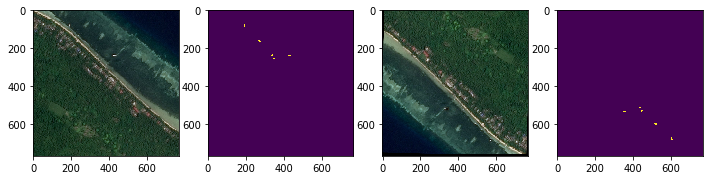

In [15]:
_, axes = plt.subplots(1,4,figsize=(12,6))
axes[0].imshow(img_x)
axes[1].imshow(img_y)
axes[2].imshow(img2x)
axes[3].imshow(img2y)
plt.show()

In [3]:
print(tf.__version__)

1.9.0


In [19]:
model.train(num_epochs, data_folder, label_df)

/home/rui/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]

evaluating validation...


 16%|█▌        | 22/140 [00:13<01:11,  1.64it/s]

KeyboardInterrupt: 

In [17]:
cv2.__version__

'3.4.2'

In [5]:
img_name = label_df.index[2]
x = cv2.imread(os.path.join(data_folder,img_name))/255.0
if label_df.loc[img_name, 'HasShip'] == 0:
    y = rle_decode_all([])
else:
    print("not zero")
    y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
print("np.sum(y)=", np.sum(y))

x = x[np.newaxis,:]
y = y.reshape((1,)+y.shape)
# image = cv2.resize(image_shape)
out = model.sess.run(model.out,feed_dict={model.x_holder:x})

not zero
np.sum(y)= 1176


In [7]:
out.shape

(1, 768, 768)

In [10]:
out = (out>0.5).astype(float)
pred = out == y
pred = pd.Series(pred.reshape((-1)))
c = pred.value_counts(normalize=True)
print(c)

True     0.921785
False    0.078215
dtype: float64


In [12]:
c = pd.Series(out.reshape((-1))).value_counts(normalize=True)
print(c)

0.0    0.923514
1.0    0.076486
dtype: float64


In [20]:
with tf.Session() as sess:
    model_dir = "./save_model"
    saver = tf.train.import_meta_graph(os.path.join(model_dir, "airbus_model.meta"))
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))

    graph = tf.get_default_graph()
    x_holder = graph.get_tensor_by_name("x_holder:0")
    y_holder = graph.get_tensor_by_name("y_holder:0")
    pixel_pred = graph.get_tensor_by_name("pixel_pred:0")
    accuracy = graph.get_tensor_by_name("accuracy:0")
    iou = graph.get_tensor_by_name("iou:0")
    
    img_name = label_df.index[2]
    x = cv2.imread(os.path.join(data_folder,img_name))/255.0
    if label_df.loc[img_name, 'HasShip'] == 0:
        y = rle_decode_all([])
    else:
        print("not zero")
        y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])

    print("np.sum(y)=", np.sum(y))

    x = x[np.newaxis,:]
    y = y.reshape((1,)+y.shape)
    
    pred, acc, iou1 = sess.run([pixel_pred, accuracy, iou], feed_dict={x_holder:x, y_holder:y})

    print(acc, iou1)

INFO:tensorflow:Restoring parameters from ./save_model/airbus_model
not zero
np.sum(y)= 1176
0.99800617 -8.5034013e-10


In [21]:
s = pd.Series(np.reshape(pred==y,(-1)))
c = s.value_counts(normalize=True)
print(c)

True     0.998006
False    0.001994
dtype: float64


In [22]:
y_true = y
y_pred = pred
intersection = np.sum(y_true * y_pred)
union = np.sum(y_true) + np.sum(y_pred) - intersection
eps = 1e-6
iou2 = -(intersection + eps) / (union + eps)
print(intersection, union, iou2)

0.0 1176.0 -8.503401353313433e-10


In [23]:
np.sum(y_pred)

0.0

In [109]:
img_name = label_df.index[2]
x = cv2.imread(os.path.join(data_folder,img_name))/255.0
if label_df.loc[img_name, 'HasShip'] == 0:
    y = rle_decode_all([])
else:
    print("not zero")
    y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
print("np.sum(y)=", np.sum(y))

x = x[np.newaxis,:]
y = y.reshape((1,)+y.shape+(1,))
# image = cv2.resize(image_shape)
out = model.sess.run(model.out,feed_dict={model.x_holder:x})
out = tf.squeeze(out)
out = tf.cast(out > 0.5, tf.float32)
out = model.sess.run(out)
print("np.sum(out)=", np.sum(out))

pred = out == np.squeeze(y)
pred = pd.Series(pred.reshape((-1)))
c = pred.value_counts(normalize=True)
print(c)

not zero
np.sum(y)= 1176
np.sum(out)= 296660.0
False    0.502957
True     0.497043
dtype: float64


In [119]:
acc = model.sess.run(model.accuracy_op,feed_dict={model.x_holder:x, model.y_holder:y})
assert round(acc,4) == round(c[True].astype(np.float32),4), " something is wrong"